In [1]:
!pip install transformers
!pip install gputil
!pip install psutil
!pip install humanize

     |████████████████████████████████| 2.1MB 15.2MB/s 
     |████████████████████████████████| 3.3MB 51.3MB/s 
     |████████████████████████████████| 870kB 54.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=1a4c99a03cc29f82e5612e4a3da71a572a54605d38134c57474de974b05107e5
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses
  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=118e2a8b315d0ba8c2703b3d2a05635b13815e57da3309372cb41a22a17ab62e
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


# Set path to movie reviews zip file

In [2]:
import zipfile
with zipfile.ZipFile("sentiment-analysis-on-movie-reviews.zip","r") as zip_ref:
    zip_ref.extractall(".")

with zipfile.ZipFile("train.tsv.zip","r") as zip_ref:
    zip_ref.extractall(".")

with zipfile.ZipFile("test.tsv.zip","r") as zip_ref:
    zip_ref.extractall(".")

In [2]:
import torch, os, random, zipfile, re, pickle, logging
import numpy as np, torch.nn as nn, pandas as pd,\
torch.nn.functional as F, matplotlib.pyplot as plt,\
seaborn as sn
from time import time, sleep
from models import BertForSentiment
from torch.optim import Adam
from string import punctuation
from sklearn.metrics import confusion_matrix
from torch.utils.data import (
    TensorDataset, 
    DataLoader, 
    Subset, 
    RandomSampler, 
    SequentialSampler, 
    Dataset
)
from sklearn.metrics import (
    roc_curve, 
    roc_auc_score, 
    precision_recall_fscore_support
)
from transformers import (
    BertTokenizer, 
    AdamW, 
    get_linear_schedule_with_warmup
)

In [4]:
class SelfDataset(Dataset):
    def __init__(self, inputs, labels, max_len):
        self.tokenizer = BertTokenizer.from_pretrained(
        'bert-base-uncased', do_lower_case=True
        )
        self.inputs = inputs
        self.labels = torch.as_tensor(
            labels, dtype=torch.long
        )
        self.max_len = max_len
    
    def __getitem__(self, item):
        encoded_dict = self.tokenizer(
            self.inputs[item],
            add_special_tokens = True,
            truncation=True,
            max_length = self.max_len,
            padding='max_length',
            return_attention_mask = True,
            return_tensors = 'pt',
        )
        return (
            encoded_dict['input_ids'].view(-1), 
            encoded_dict['attention_mask'].view(-1), 
            self.labels[item]
        )
    
    def __len__(self):
        return self.labels.size()[0]

class TrainTest():
    def __init__(self, model, optimizer, scheduler, criterion, logger=None, method='cls'):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = criterion
        self.logger = logger
        self.method = method
        self.tr_metrics = {
            'train_loss':[],
            'train_accuracy':[],
            'valid_loss':[],
            'valid_accuracy':[],
        }
        
    def train(
        self, train_loader, valid_loader, 
        num_epochs, device, eval_interval,
        clip=None, model_path=None, save_per_epoch=None,
        results_path=None, defaults=None, **kwargs
    ):
        total_itrs = num_epochs*len(train_loader)
        num_tr, total_tr_loss, itr = 0, 0, 0
        self.model.train()
        for epoch in range(num_epochs):
            for i, (input_ids, att_masks, input_labels) in enumerate(train_loader):
                input_ids = input_ids.to(device)
                att_masks = att_masks.to(device)
                input_labels = input_labels.to(device)
                self.optimizer.zero_grad()
                output = self.model(
                    input_ids,
                    attention_mask=att_masks,
                    token_type_ids=None,
                    method=self.method
                )
                tr_loss = self.criterion(output, input_labels.view(-1))
                # nn.utils.clip_grad_norm_(model.parameters(), clip)
                if self.logger:
                    self.logger.info(f'Training: {itr}/{total_itrs} -- loss: {tr_loss.item()}')
                tr_loss.backward()
                self.optimizer.step()
                self.scheduler.step()
                num_tr += 1
                total_tr_loss += tr_loss
                if itr % eval_interval == 0 or itr+1 == total_itrs:
                    self.tr_metrics['train_loss'].append(total_tr_loss.cpu().item()/num_tr)
                    tr_accuracy = cal_accuracy(output, input_labels)
                    self.tr_metrics['train_accuracy'].append(tr_accuracy)
                    num_tr, total_tr_loss = 0, 0
                    val_loss = 0
                    self.model.eval()
                    val_accuracy = []
                    with torch.no_grad():
                        for val_ids, val_masks, val_labels in valid_loader:
                            val_ids = val_ids.to(device)
                            val_masks = val_masks.to(device)
                            val_labels = val_labels.to(device)
                            val_output = self.model(
                                val_ids,
                                attention_mask=val_masks,
                                token_type_ids=None,
                                method=self.method
                            )
                            val_loss += self.criterion(val_output, val_labels.view(-1))
                            val_accuracy.append(cal_accuracy(val_output, val_labels))
                    self.tr_metrics['valid_accuracy'].append(np.mean(val_accuracy))
                    self.tr_metrics['valid_loss'].append(val_loss.cpu().item()/len(valid_loader))
                    self.model.train()
                    if self.logger:
                        self.logger.info(f'Training: iteration: {itr}/{total_itrs} -- epoch: {epoch} -- '
                        f' train_loss: {self.tr_metrics["train_loss"][-1]:.3f} -- train_accuracy: {self.tr_metrics["train_accuracy"][-1]:.2f}'
                        f' valid_loss: {self.tr_metrics["valid_loss"][-1]:.3f} -- valid_accuracy: {self.tr_metrics["valid_accuracy"][-1]:.2f}')
                itr += 1
            if model_path and results_path and ((epoch+1) % save_per_epoch == 0) and epoch != 0:
                self.save_model(epoch+1, model_path, f'{epoch+1}_epochs_train')
                self.save_results(results_path, f'{epoch+1}_epochs_train', self.tr_metrics)
        if model_path and results_path:
            self.save_model(epoch+1, model_path, f'{epoch+1}_epochs_last_train')
            self.save_results(results_path, f'{epoch+1}_epochs_last_train', self.tr_metrics)
            
    def save_model(self, epoch, model_path, name):
        model_dir = '/'.join(model_path.split('/')[:-1])
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'scheduler_state_dict': self.scheduler.state_dict(),
                'loss': self.tr_metrics['valid_loss'][-1],
            }, os.path.join(model_dir, f'model_{name}.pt')
        )
        if self.logger:
            self.logger.info(f'Training: model saved to: {model_dir}/model_{name}.pt')
    
    def save_results(self, results_path, name, results):
        results_dir = '/'.join(results_path.split('/')[:-1])
        if not os.path.exists(results_dir):
            os.makedirs(results_dir)
        with open(os.path.join(results_dir, f'results_{name}.pkl'), 'wb') as save_file:
            pickle.dump(results, save_file)
        if self.logger:
            self.logger.info(f'Training: results saved to: {results_dir}/resutls_{name}.pkl')

    def test(test_loader, device, all_labels, results_path=None, defaults=None):
        test_accuracy, test_true, test_pred = [], [], []
        test_loss = 0
        self.model.eval()
        with torch.no_grad():
            for test_ids, test_masks, test_labels in test_loader:
                test_ids = test_ids.to(device)
                test_masks = test_masks.to(device)
                test_labels = test_labels.to(device)
                test_output = self.model(
                    test_ids,
                    attention_mask=test_masks,
                    token_type_ids=None,
                    method=self.method
                )
                test_loss += self.criterion(test_output, test_labels.view(-1))
                test_accuracy.append(cal_accuracy(test_output, test_labels))
                test_true.append(test_labels.cpu())
                test_pred.append(test_output.cpu().max(dim=1)[1])
        test_true = torch.cat(test_true)
        test_pred = torch.cat(test_pred)
        test_loss = test_loss.cpu().item()/len(test_loader)
        test_accuracy = np.mean(test_accuracy)
        prf = precision_recall_fscore_support(
            test_true,
            test_pred,
            labels=all_labels,
            average='weighted'
        )
        confm = confusion_matrix(test_true, test_pred, labels=all_labels)
        self.ts_metrics = {
            'loss':test_loss,
            'accuracy':test_accuracy,
            'precision':prf[0],
            'recall':prf[1],
            'f1_score':prf[2],
            'confusion_matrix':confm
        }
        if self.logger:
            print(f'Testing: test_loss: {test_loss:.3f} -- test_accurcy: {test_accuracy:.2f}')
        if results_path:
            self.save_results(results_path, f'test', self.ts_metrics)

In [5]:
def download_dirs(dirlist):
    from google.colab import files
    for dirname in dirlist:
        for filename in os.listdir(dirname):
            filename = os.path.join(dirname, filename)
            files.download(filename)
            
def get_dataLoader(dataset, splits, batch_sizes, shuffle_indices, **kwargs):
    n_samples = len(dataset)
    indices = list(range(n_samples))
    if shuffle_indices:
        np.random.shuffle(indices)
    split_index = int(n_samples*splits[0])
    train_indices = indices[:split_index]
    valid_indices = indices[split_index:]
    train_dataset = Subset(dataset, train_indices)
    valid_dataset = Subset(dataset, valid_indices)
    train_loader = DataLoader(
        train_dataset, shuffle=True, batch_size=batch_sizes[0], **kwargs
    )
    valid_loader = DataLoader(
        valid_dataset, shuffle=False, batch_size=batch_sizes[1], **kwargs
    )
    return train_loader, valid_loader

def fix_seed(seed_value, random_lib=False, numpy_lib=False, torch_lib=False):
    if random_lib:
        random.seed(seed_value)
    if numpy_lib:
        np.random.seed(seed_value)
    if torch_lib:
        torch.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)

def setup_logger(name, format=None, level=logging.DEBUG, handlers=None, log_file='default.log'):
    logging.basicConfig(
        level=level, 
        format=format if format else '%(asctime)s [%(levelname)s] %(message)s',
        handlers=handlers if handlers else [
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(name)
    logger.setLevel(level)

def cal_accuracy(pred_labels, true_labels):
    _, pred_labels = pred_labels.max(dim=1)
    true_labels = true_labels.view(-1)
    return torch.sum(pred_labels == true_labels).item() / true_labels.size()[0]

In [28]:
cuda_flag = True if torch.cuda.is_available() else False
lrlast = .001
lrmain = .00001
n_iters = 10000
num_epochs = 1
eval_interval = 150
save_model = True
device = torch.device('cuda' if cuda_flag else 'cpu')
params = {'num_workers': 2, 'pin_memory': True} if cuda_flag else {}
data_splits = [0.85, 0.15]
batch_sizes = [64, 64]
seed = 20214
fix_seed(seed, random_lib=True, numpy_lib=True, torch_lib=True)

# Set path to train .tsv file

In [29]:
tr_phrases = pd.read_csv(
    'train.tsv', 
    sep='\t', engine='python', header=0)

# Set path to GloVe 300d embedding fil

In [18]:
augment = False
aug_method = 'embedding'
if augment:
    tr_phrases['len_sent'] = tr_phrases.Phrase.apply(lambda x: len(x.split()))
    cand_df = tr_phrases[tr_phrases.len_sent>5].sample(int(len(tr_phrases)*0.1), random_state=2020).reset_index(drop=True)
    
    if aug_method == 'embedding':
        from sklearn.neighbors import NearestNeighbors
        from string import punctuation
        embedded_words = dict()
        glove_path = '/content/drive/My Drive/GLOVE/glove.42B.300d.txt'
        glove_file = open(glove_path)
        for line in glove_file:
            values = line.split(' ')
            word = values[0]
            words_weights = np.array(values[1:], dtype='float32')
            embedded_words[word] = words_weights
        glove_file.close()
        mean_embedding = np.array(list(embedded_words.values())).mean(axis=0)
        values = []
        keys = []
        for key, value in embedded_words.items():
            keys.append(key)
            values.append(value)
        neigh = NearestNeighbors(n_neighbors=2, radius=0.4)
        neigh.fit(values)
    elif aug_method == 'synonym':
        import nltk
        from nltk.corpus import wordnet
        all_words = list(wordnet.all_lemma_names(pos='n', lang='eng'))

    def word_replace(sent, method):
        sent = sent.lower()
        sent = sent.split()
        clean_sent = [word for word in sent if word not in punctuation]
        if method == 'embedding':
            cand_word = np.random.choice(clean_sent)
            try:
                cand_embed = embedded_words[cand_word]
            except:
                print('word not found')
                cand_embed = mean_embedding
            alt_word_idx = neigh.kneighbors(cand_embed.reshape(1, -1), 2, return_distance=False)[0, 1]
            alt_word = keys[alt_word_idx]
        elif method == 'synonym':
            not_found = True
            alt_word = np.random.choice(all_words)
            checked_words = 0
            while not_found and checked_words < 2*len(clean_sent):
                cand_word = np.random.choice(clean_sent)
                checked_words += 1
                if cand_word not in all_words:
                    continue
                syns = wordnet.synsets(cand_word)
                for syn in syns:
                    syn_word = syn.lemmas()[0].name()
                    if syn_word != cand_word:
                        not_found = False
                        alt_word = syn_word
                        break
        sent[sent.index(cand_word)] = alt_word
        sent = ' '.join(sent)
        return sent

    cand_df['Phrase'] = cand_df.Phrase.apply(lambda x: word_replace(x, aug_method))
    tr_phrases = pd.concat([tr_phrases, cand_df], ignore_index=True)
    aug_path = './augmented_train.csv'
    tr_phrases.to_csv(aug_path, sep='\t', header=True)
    tr_file_path = aug_path
else:
    tr_file_path = 'train.tsv'

In [30]:
single_sentence = True
if single_sentence:
    max_pad = 100
else:
    tr_phrases['Phrase'] = tr_phrases.Phrase.apply(lambda x: x+' [SEP] '+x)
    max_pad = 150

In [31]:
tr_dataset = SelfDataset(
    inputs=tr_phrases.Phrase.values,
    labels=tr_phrases.Sentiment.values,
    max_len=max_pad
)
train_loader, valid_loader = get_dataLoader(
    tr_dataset,
    data_splits,
    batch_sizes,
    shuffle_indices=True, **params
)
print(f'number of epochs: {num_epochs}')
print(f'number of iteration: {num_epochs*len(train_loader)}')
print(f'number of intervals: {num_epochs*len(train_loader)/eval_interval}')

2021-04-16 19:10:29,924 [DEBUG] Starting new HTTPS connection (1): huggingface.co:443
2021-04-16 19:10:30,195 [DEBUG] https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/vocab.txt HTTP/1.1" 200 0
2021-04-16 19:10:30,199 [DEBUG] Starting new HTTPS connection (1): huggingface.co:443
2021-04-16 19:10:30,493 [DEBUG] https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/added_tokens.json HTTP/1.1" 404 0
2021-04-16 19:10:30,498 [DEBUG] Starting new HTTPS connection (1): huggingface.co:443
2021-04-16 19:10:30,766 [DEBUG] https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/special_tokens_map.json HTTP/1.1" 404 0
2021-04-16 19:10:30,770 [DEBUG] Starting new HTTPS connection (1): huggingface.co:443
2021-04-16 19:10:31,041 [DEBUG] https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2021-04-16 19:10:31,045 [DEBUG] Starting new HTTPS connection (1): huggingface.co:443
2021-04-16 19:10:31,319 [DEBUG] https://hugg

number of epochs: 1
number of iteration: 2280
number of intervals: 15.2


In [32]:
vocab_file = 'bert-base-uncased'
model = BertForSentiment(vocab_file, num_classes=5, contain_cls=True).to(device)
optimizer = Adam([
#     {"params":model.bert.parameters(),"lr": lrmain},
    {"params":model.dropout.parameters(), "lr": lrlast},
    {"params":model.classifier.parameters(), "lr": lrlast},                    
])
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = 0,
    num_training_steps = 2000
)
for param in model.bert.parameters():
    param.requires_grad = False

open('metrics.log', 'w').close()
logger = setup_logger(name='track_logger', log_file='metrics.log')

2021-04-16 19:10:31,737 [DEBUG] Starting new HTTPS connection (1): huggingface.co:443
2021-04-16 19:10:32,004 [DEBUG] https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/config.json HTTP/1.1" 200 0
2021-04-16 19:10:32,011 [DEBUG] Starting new HTTPS connection (1): huggingface.co:443
2021-04-16 19:10:32,279 [DEBUG] https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/pytorch_model.bin HTTP/1.1" 302 0


In [33]:
traintest = TrainTest(model, optimizer, scheduler, F.nll_loss, logger, method='avg')
traintest.train(
    train_loader,
    valid_loader,
    num_epochs,
    device,
    eval_interval,
    model_path='./models/',
    save_per_epoch=10,
    results_path='./results/',
    clip=5
)

/content/bert_net.py:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_logits = F.log_softmax(logits)
2021-04-16 19:10:35,047 [INFO] Training: 0/2280 -- loss: 1.6602613925933838
2021-04-16 19:11:51,596 [INFO] Training: iteration: 0/2280 -- epoch: 0 --  train_loss: 1.660 -- train_accuracy: 0.20 valid_loss: 1.466 -- valid_accuracy: 0.49
2021-04-16 19:11:51,795 [INFO] Training: 1/2280 -- loss: 1.4928644895553589
2021-04-16 19:11:51,996 [INFO] Training: 2/2280 -- loss: 1.4065611362457275
2021-04-16 19:11:52,194 [INFO] Training: 3/2280 -- loss: 1.379309892654419
2021-04-16 19:11:52,391 [INFO] Training: 4/2280 -- loss: 1.3166956901550293
2021-04-16 19:11:52,590 [INFO] Training: 5/2280 -- loss: 1.249629020690918
2021-04-16 19:11:52,789 [INFO] Training: 6/2280 -- loss: 1.4450665712356567
2021-04-16 19:11:52,988 [INFO] Training: 7/2280 -- loss: 1.2083334922790527
2021-04-16 19:11:53,185 [INFO] Training: 8/2280 

In [34]:
download_dirs(['./results/'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
traintest.tr_metrics

{'train_accuracy': [0.203125,
  0.625,
  0.71875,
  0.578125,
  0.53125,
  0.6875,
  0.625,
  0.640625,
  0.53125,
  0.578125,
  0.703125,
  0.5625,
  0.59375,
  0.734375,
  0.703125,
  0.578125,
  0.5666666666666667],
 'train_loss': [1.6602613925933838,
  1.1046338907877604,
  0.9993491617838541,
  0.9763283284505209,
  0.9671751912434896,
  0.9612545776367187,
  0.958063252766927,
  0.9539402262369792,
  0.9642760213216146,
  0.9491306559244792,
  0.9526850382486979,
  0.9508075968424479,
  0.9490553792317709,
  0.9542727661132813,
  0.9501153564453125,
  0.9583950805664062,
  0.96353162568191],
 'valid_accuracy': [0.49143145161290325,
  0.5906376889239793,
  0.6052581491089556,
  0.6054484829686443,
  0.6126564967290774,
  0.6107602075344011,
  0.6088921159485676,
  0.6145633600270697,
  0.6158745488382585,
  0.6181268328445747,
  0.6175840288743514,
  0.6196777013309271,
  0.6203755921497857,
  0.6196389296187683,
  0.6201817335889916,
  0.6201817335889916,
  0.6201817335889916],
 

In [14]:
def report_results(
    results_dir, train_results_files, eval_interval, variations,
    loss_img_name='', accuracy_img_name='', **kwargs
):
    results = []
    for i in range(len(train_results_files)):
        with open(os.path.join(results_dir, train_results_files[i]), 'rb') as results_file:
            train_results = pickle.load(results_file)
            iterations = [i*eval_interval for i in range(len(train_results['train_loss']))]
            results.append((train_results, variations[i], iterations))
    plt.figure()
    for result in results:
        plt.plot(result[2], result[0]['train_loss'], label=f'train loss {result[1]}')
        plt.plot(result[2], result[0]['valid_loss'], label=f'valid loss {result[1]}')
    plt.title('Loss')
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.legend()
    plt.savefig(os.path.join(results_dir, loss_img_name+'train-validation-loss.png'), dpi=300, bbox_inches="tight")
    plt.figure()
    for result in results:
        plt.plot(result[2], result[0]['train_accuracy'], label=f'train accuracy {result[1]}')
        plt.plot(result[2], result[0]['valid_accuracy'], label=f'valid accuracy {result[1]}')
    plt.title('Accuracy')
    plt.xlabel('iterations')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig(os.path.join(results_dir, accuracy_img_name+'train-validation-accuracy.png'), dpi=300, bbox_inches="tight")

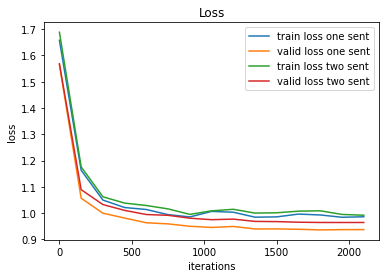

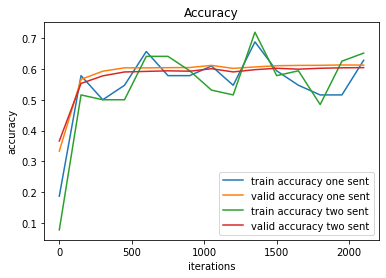

In [18]:
results_dir = 'sentiment-results'
train_results_files = [
    'resutls_one_sent_input_cls.pkl', 'results_two_sent_input_cls.pkl'
]
variations = ['one sent', 'two sent']
eval_interval = 150
report_results(
    results_dir, train_results_files, eval_interval, variations,
    loss_img_name='input_', accuracy_img_name='input_'
)

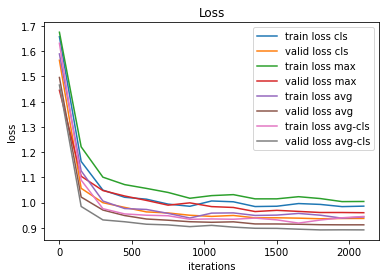

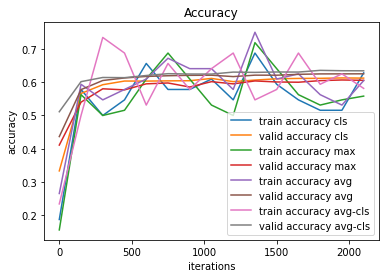

In [19]:
results_dir = 'sentiment-results'
train_results_files = [
    'resutls_one_sent_input_cls.pkl',
    'resutls_one_sent_input_max.pkl',
    'resutls_one_sent_input_avg.pkl',
    'resutls_one_sent_input_avg_cls.pkl'
]
variations = ['cls', 'max', 'avg', 'avg-cls']
eval_interval = 150
report_results(
    results_dir, train_results_files, eval_interval, variations,
    loss_img_name='output_', accuracy_img_name='output_'
)

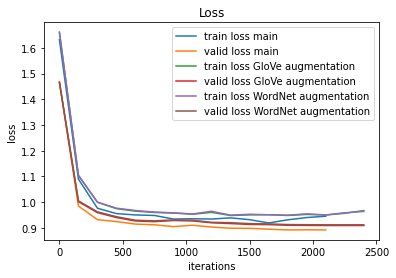

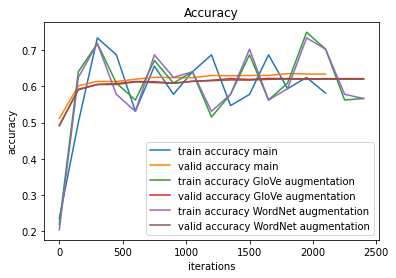

In [24]:
results_dir = 'sentiment-results'
train_results_files = [
    'resutls_one_sent_input_avg_cls.pkl',
    'resutls_one_sent_input_avg_cls_embedding_augment.pkl',
    'resutls_one_sent_input_avg_cls_synonym_augment.pkl',
]
variations = ['main', 'GloVe augmentation', 'WordNet augmentation']
eval_interval = 150
report_results(
    results_dir, train_results_files, eval_interval, variations,
    loss_img_name='augmentation_', accuracy_img_name='augmentation_'
)